# Model Grid Analysis

We will analyze the results of the 100 Model Grids obtained from the 100 data
shuffles. First step, is to average results together and plot the *definitive*
plot. Next step will be to plot only the results of the simplified model grid.
This will only include saline, mPFC, Contra and Naive.

Next step will be devising some kind of statistic. Maybe some kind of clustering
analysis. We will have to do more research on this


In [1]:
import os
import sys
ROOT = os.environ['HOME'] + '/python/behavioral_performance/'
sys.path.append(ROOT)

In [31]:
import pickle
import copy
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from Visualize.decoding import plot_model_grid_general
import seaborn as sns
import scipy
source = ROOT + 'Results/MODEL_GRIDS/'

## Cross-Validated Plot
First we just want a simple average of all cross-validation runs. We'll create a pandas panel and take the mean across all shuffles. 

/Applications/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2882: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  exec(code_obj, self.user_global_ns, self.user_ns)


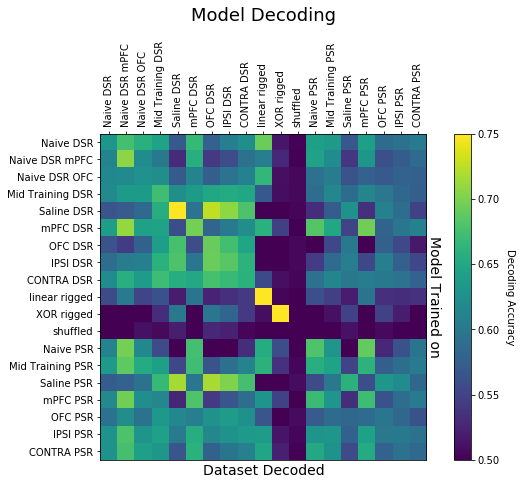

In [3]:
GRID_DICT = {}
for mg in [w for w in os.listdir(source) if w.find('MODEL')==0]:
    GRID = pickle.load(open(source + mg, 'rb'))
    GRID_DICT[mg] = GRID

panel = pd.Panel(GRID_DICT)
MASTER_GRID = panel.mean(axis=0)
plot_model_grid_general(MASTER_GRID, vrange=[0.5, 0.75])

In [12]:
'''
"mirrors" each matrix by taking average between 2 values opposite of the
diagonal. For example, PSR Saline decoding DSR mPFC and DSR mPFC decoding
PSR Saline.
'''
def transform_matrix(grid):
    M = 1 - grid.values
    D = np.full(M.shape, np.NaN)
    for i,j in itertools.product(range(len(M)), range(len(M))):
        D[i,j] = (M[i,j] + M[j,i]) / 2
    return D

## t-SNE as a Clustering Technique
I'm not really sure this if this is going to work. The intuition is as follows: I want the plot above to be something like a similarity distribution: if a model trained on a particular dataset can decode another dataset well, then their similarity score should be high. If it can't decode it well, it should be lower. An intermediate step of t-SNE (stochastic neighbor embedding) takes such a similarity matrix and embeds the points in a lower-dimensional space that can be visualized. We could conceive of our data as 19-dimensional (since there are 19 datasets), and we want to see if certain points cluster once embedded in a lower dimension. 

In [17]:

X = 1 - panel.to_frame()
tsne = TSNE(n_components=2, verbose=1)
tsne_reduct = tsne.fit_transform(X.values)
tsne_reduct = pd.DataFrame(tsne_reduct, index=X.index)


#for master grid
M = transform_matrix(1 - MASTER_GRID)
tsne = TSNE(n_components=2, verbose=1, metric='precomputed')
tsne_reduct = tsne.fit_transform(M)
tsne_reduct = pd.DataFrame(tsne_reduct, index=MASTER_GRID.index)
tsne_reduct.index.set_names(['major'], inplace=True)



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 361 samples in 0.001s...
[t-SNE] Computed neighbors for 361 samples in 0.026s...
[t-SNE] Computed conditional probabilities for sample 361 / 361
[t-SNE] Mean sigma: 0.145395
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.413746
[t-SNE] Error after 1000 iterations: 0.423567
[t-SNE] Computing 18 nearest neighbors...
[t-SNE] Indexed 19 samples in 0.000s...
[t-SNE] Computed neighbors for 19 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 19 / 19
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.691513
[t-SNE] Error after 1000 iterations: 0.392479


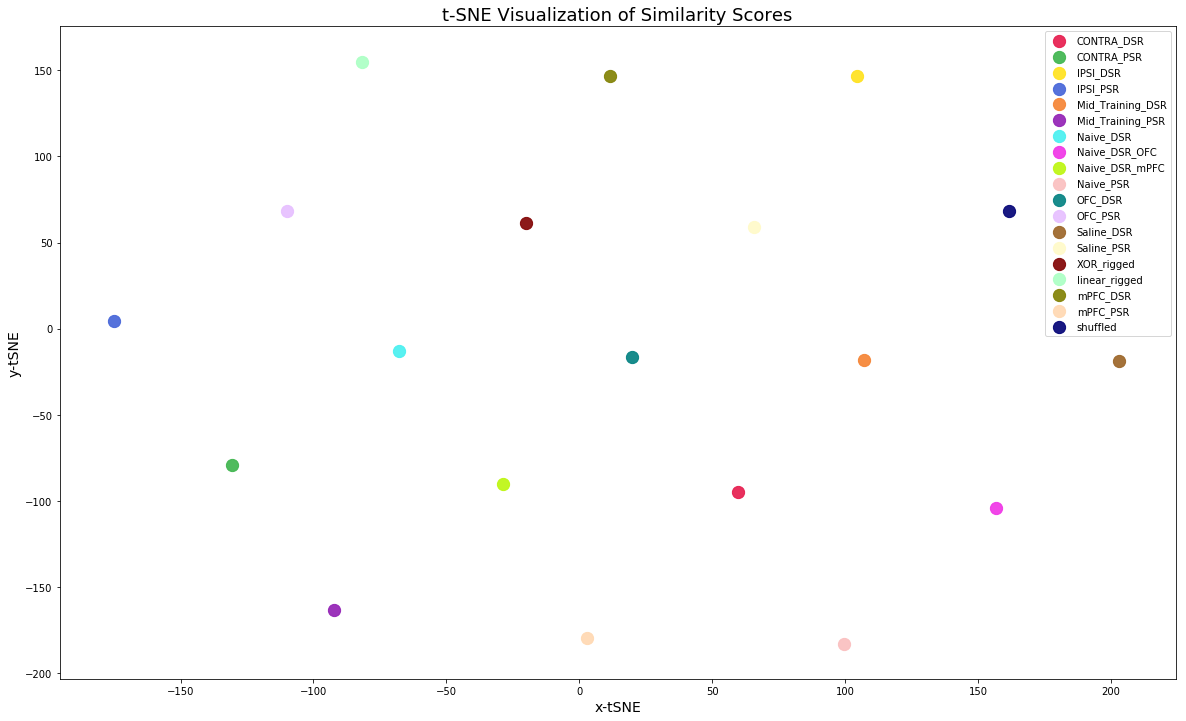

In [20]:
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
          '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff',
          '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1',
          '#000075', '#808080', '#ffffff', '#000000']


fig, ax = plt.subplots(figsize=(20,12))
for i, (label, data) in enumerate(tsne_reduct.groupby('major')):
    #cc = tuple([np.float(w)/255 for w in colors[i]])
    cc = colors[i]
    ax.scatter(data.values[:,0], data.values[:,1],
                                color=cc,
                                label=label,
                                alpha = 0.9,
                                s=150)
ax.legend()
plt.xlabel('x-tSNE', fontSize=14)
plt.ylabel('y-tSNE', fontSize=14)
plt.title('t-SNE Visualization of Similarity Scores', fontSize=18)
plt.show()

For now, this did not work. 

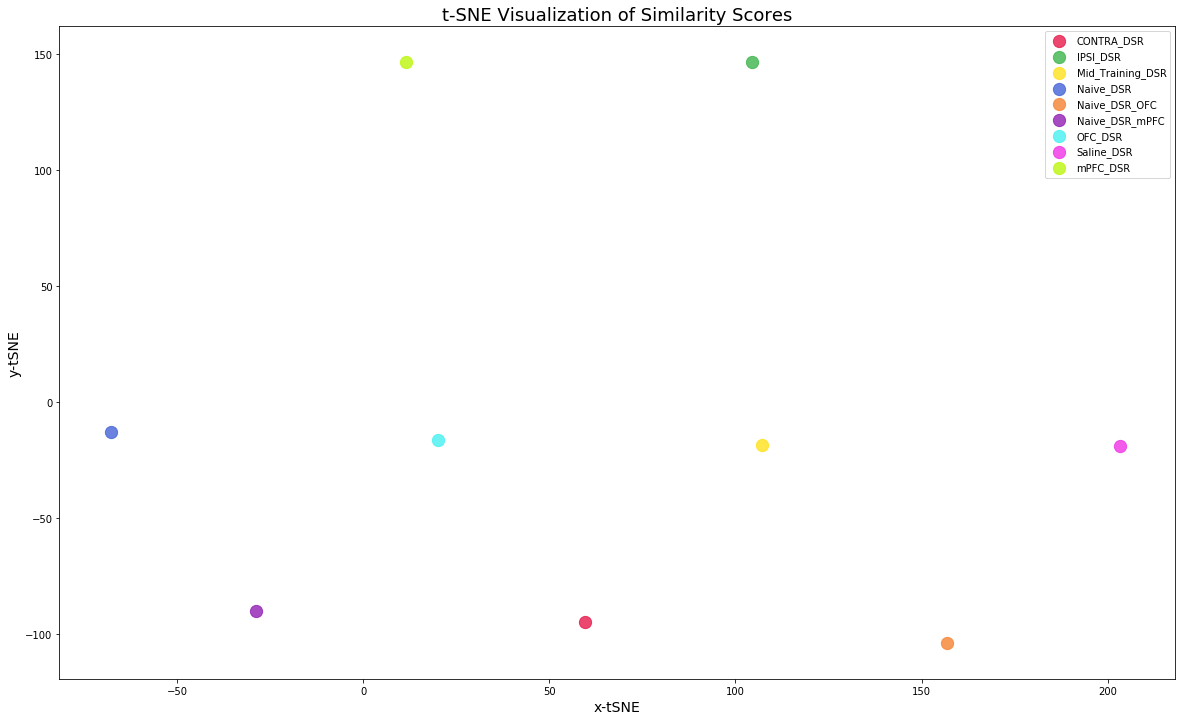

In [21]:
'''
Let's try DSR only
'''
fig, ax = plt.subplots(figsize=(20,12))
j = 0
for i, (label, data) in enumerate(tsne_reduct.groupby('major')):
    if label.find('DSR')>=0:
        cc = colors[j]
        j += 1
        ax.scatter(data.values[:,0], data.values[:,1],
                                    color=cc,
                                    label=label,
                                    alpha = 0.8,
                                    s=150)
ax.legend()
plt.xlabel('x-tSNE', fontSize=14)
plt.ylabel('y-tSNE', fontSize=14)
plt.title('t-SNE Visualization of Similarity Scores', fontSize=18)
plt.show()

## Hierarchical Clustering
Let's try something simpler. For starters we're getting rid of the rigged and shuffled datasets. We are not interested in how they relate to the rest of the data, they were there as confidence measures which they passed. We're going to to do hierarchical clustering because it has very few underlying assumptions about the data, it works by clustering by distance or similarity, which is kind of what we have with the accuracy scores. Furthermore, it is nice to visualize as dendrograms. The implementation is super easy. 

In [29]:
condensed = ['Naive_DSR',
             'Naive_DSR_mPFC',
             'Naive_DSR_OFC',
             'Mid_Training_DSR',
             'Saline_DSR',
             'mPFC_DSR',
             'OFC_DSR',
             'IPSI_DSR',
             'CONTRA_DSR',
             'Naive_PSR',
             'Mid_Training_PSR',
             'Saline_PSR',
             'mPFC_PSR',
             'OFC_PSR',
             'IPSI_PSR',
             'CONTRA_PSR']
idx = pd.IndexSlice
reduced_grid = MASTER_GRID.loc[idx[condensed], idx[condensed]]

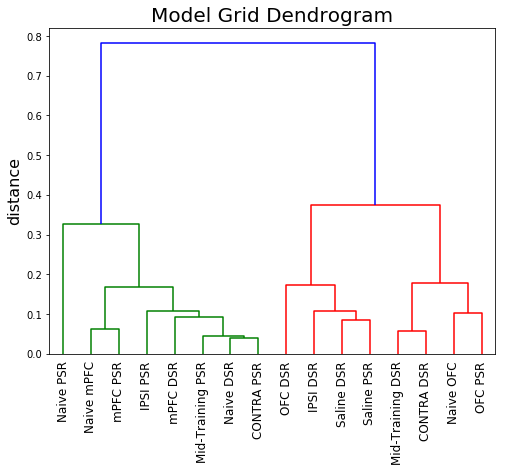

In [39]:
from scipy.cluster.hierarchy import linkage, dendrogram

pretty_labels = ['Naive DSR',
             'Naive mPFC',
             'Naive OFC',
             'Mid-Training DSR',
             'Saline DSR',
             'mPFC DSR',
             'OFC DSR',
             'IPSI DSR',
             'CONTRA DSR',
             'Naive PSR',
             'Mid-Training PSR',
             'Saline PSR',
             'mPFC PSR',
             'OFC PSR',
             'IPSI PSR',
             'CONTRA PSR']


plt.figure(figsize=(8,6))
plt.title('Model Grid Dendrogram', fontsize=20)
plt.ylabel('distance', fontsize=16)

z = linkage(1-reduced_grid, 'ward')
d = dendrogram(z, labels=pretty_labels, leaf_rotation=90)
plt.savefig(ROOT + 'Results/Figures/dendrogram.jpg', dpi=800, bbox_inches='tight')
plt.show()

That's all I really wanted. When something is really visible in the original plot it should come out easily from the quantification. I do not know why t-SNE did not work, in general we should not try the most complicated method before exploring all other alternatives. Whatever, we're done here.